In [388]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['f', 'exp', 'table']
`%matplotlib` prevents importing * from pylab and numpy



In [394]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [390]:
from sorf_query import *
from transcript_features import *
import jsonlines
import pandas as pd
from types import SimpleNamespace
import plotly.express as px
import seaborn as sns

In [380]:
row = df.T['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
row = row.apply(convert_to_integer_array)
row.name

'MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ'

In [450]:
    row = df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    row

Deepsig          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 6slow    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 5b       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
SignalP 4.1      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Phobius          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [451]:
textrow

Deepsig          [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 6slow    [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 5b       [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
SignalP 4.1      [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
Phobius          [S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, S, O, O, O, O, O, O, O, O, O, O, O, O, O, O]
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [456]:
    row = df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    imdf = pd.DataFrame(index = [i for i in row.name])
    textdf = pd.DataFrame(index = [i for i in row.name])
    for ix, row in row.items():
        imdf[ix] = row
        textdf[ix] = textrow.loc[ix]
#     return imdf.T, textdf

In [483]:
def features_to_int_arrays(row):
    char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
    convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])
    textrow = row.apply(lambda x: [i for i in x]).copy()
    row = row.apply(convert_to_integer_array)
    imdf = pd.DataFrame(index = [i for i in row.name])
    textdf = pd.DataFrame(index = [i for i in row.name])
    for ix, row in row.items():
        imdf[ix] = row
        textdf[ix] = textrow.loc[ix]
    return imdf.T, textdf.T


In [478]:
df.index

Index(['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ',
       'MRGTSCVGGGAESPGGAGLSEGPRGRWLRLAPVCAYFLCVSLAAVLLAVYYGLIWVPTRSPAAPAGPQPSAPSPPCAARPGVPPVPAPAAASLSCLLGVPGGPRPQLQLPLSRRRRYSDPDRRPSRQTPRETPEAAEGRRPG',
       'MACTLSSLPLYLSTSFCSWHYLFPILFPLSY',
       'ALSLLLSWASLAADGSAAVVSWGREWVVGGGWSARTLWCVSKQGQLPVPAPNLESQNLRTKGTCVI',
       'LADLGRRCTRKVRPRAL', 'MGLYLFWGLTALPAGDRQSLVGFPPVETQYFGNICI',
       'MKERDAAPAERGKPATYTGDKKAKMAAKTNKKWVRLATVFAYVLSVSLAAIVLAVYYSLIWQPVGAGTSGGAAGPPPGGSNATGPSGTSGAAAAGPNTTGSSRREAPRDVPPLQAARPAPPEPPADSPPAGPLERPRGPDEDEEETAAAPGSR',
       'MSSITLPQWWNLSQFSGRIFMQLPRWLHW',
       'LVNASALFLLLLLNLVLIGRQDRLKRREVERRLRGIIDQIQGEVKGRHIGGKR',
       'MSTRGVDAPLAVAS',
       ...
       'LRAAEVAGSFKMRLLLLLLVAASAMVRSEASANLGGVPSKRLKMQYATGPLLKFQI',
       'MYVSISFLLGLSHLVLCCLLTFIVNFYLPPESIDFEFMAHNWSKGRSPSSTLGLSWFKAGFRFSDGWSMFYSFGLPGVALPGSPPRSHLLPGTQILIRSFQPCESAKHSARLSSLLTTTSYSVS',
       'VAGSFKMRLLLLLLVAASAMVRSEASANLGGVPSKRLKMQYATGPLLKFQI',
       'LATPCMQAGLVLCCASWVAVSSSAALEMPRPLVKTVST

In [510]:
import plotly.figure_factory as ff
imdf, textdf = features_to_int_arrays(df.loc['LVNASALFLLLLLNLVLIGRQDRLKRREVERRLRGIIDQIQGEVKGRHIGGKR'])
imdf.loc['aa'] = imdf.columns
imdf.columns = np.arange(imdf.shape[1])


In [511]:
import plotly.graph_objects as go
colorscale = [[0, '#454D59'], [0.25, '#FFFFFF'], [0.5, '#F1C40F'], [0.75, '#336641']]
# fig = ff.create_annotated_heatmap(z = imdf, x=imdf.columns, y=imdf.index, text=textdf.values)
fig = go.Figure(data=go.Heatmap(z=imdf.values, x=imdf.columns, y=imdf.index[:-1],
                                colorscale='Picnic', text=textdf.values, zmin=0, zmax=3,
                                showlegend=False, showscale=False))
# fig.update_coloraxes(showscale=False, showlegend=False)
fig.show()

<Axes: >

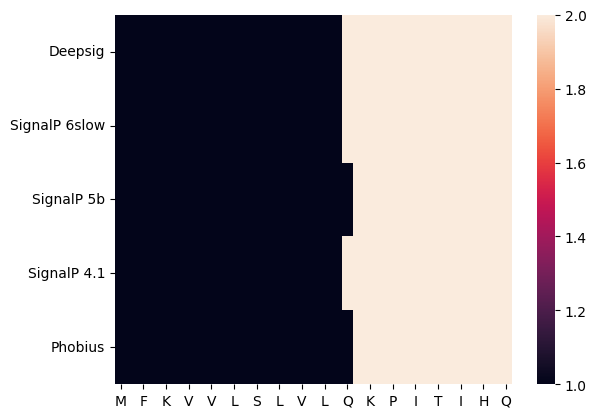

In [392]:
char_to_int = {'S': 1, 'C': 0, 'O': 2, 'M': 3}
convert_to_integer_array = lambda x: np.array([char_to_int[i] for i in x])


row = df.T['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']
row = row.apply(convert_to_integer_array)
imdf = pd.DataFrame(index = [i for i in row.name])
for ix, row in row.items():
    imdf[ix] = row
sns.heatmap(imdf.T)

In [395]:
px.imshow(imdf.T)

In [372]:
row

'SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO'

In [324]:
px.imshow(row.apply(convert_to_integer_array).values)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [397]:
df.loc['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ']

Deepsig          SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
SignalP 6slow    SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
SignalP 5b       SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO
SignalP 4.1      SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO
Phobius          SSSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOO
Name: MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ, dtype: object

In [318]:
df = pd.read_parquet('../../data/sequence_features_strings.parq')
px.imshow(df.T['MRFKKIVLVILCSTLQVILHQEKAPNILTTIQHFQ'].astype('int').values)

ValueError: invalid literal for int() with base 10: 'SSSSSSSSSSSSSSSSSSSSOOOOOOOOOOOOOOO'

In [2]:
    input_file = './test_vtx.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_(ids[::100]+[673319])).all()
    orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    # if len(missing_orfs) > 0:
        # print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)

In [305]:
        sum_expression_cancer = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
        sum_expression_cancer['condition'] = 'Cancer'
        sum_expression_normal = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['GTEx Average'] for tid in  tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
        sum_expression_normal['condition'] = 'GTEx'
        de = pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['padj']<0.001 for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0)
        result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
        result['TCGA'] = result.index
        result['# DE Transcripts'] = [de.loc[i] for i in result.index]

In [310]:
list(new_df['Cancer'].values)

[0.68280286,
 313.34976,
 31.258528,
 70.325745,
 9.663325,
 611.9515,
 3.810155,
 168.0931,
 6.4587927,
 17.2023,
 1.8330371,
 2.505923,
 4.115969,
 3.508106,
 8.447077,
 28.318516,
 27.528933,
 1.5112278,
 19.575867,
 117.11811,
 14.005225,
 22.613775,
 545.16693,
 6.5105386,
 2.6331255,
 459.00186,
 10.07481,
 1.4261916,
 36.250904,
 7.697706,
 0.10556518]

In [307]:
group_name = 'TCGA'
new_df = pd.DataFrame()
for g, subdf in result.groupby('condition'):
    new_df[g] = subdf['Sum']
new_df[group_name] = subdf[group_name]
new_df

,Cancer,GTEx,TCGA
ACC,0.682803,3.722827,ACC
BLCA,313.349760,362.208740,BLCA
BRCA,31.258528,11.201046,BRCA
CESC,70.325745,83.976920,CESC
CHOL,9.663325,16.666649,CHOL
COAD,611.951500,728.239750,COAD
DLBC,3.810155,0.195709,DLBC
ESCA,168.093100,87.624054,ESCA
GBM,6.458793,10.302282,GBM
HNSC,17.202300,93.200554,HNSC


In [254]:
match

,Unnamed: 0,qName,qSize,matches,misMatches,tName,strand,tStart,tEnd,tStarts,blockCount,blockSizes,tSize,phase,reading_frame,phylocsf_58m_avg,phylocsf_58m_max,phylocsf_58m_min,phylocsf_58m_std,phylocsf_vals


In [258]:
df.iloc[350]

Unnamed: 0                                                                                                                                                                                                             2846
qName                                                                                                                                                                                                           Phase_6_357
qSize                                                                                                                                                                                                                    69
matches                                                                                                                                                                                                                  69
misMatches                                                                                                              

In [275]:
kibby = pd.read_csv('../../data/phase1to6_kibby.csv', index_col=0)
kibby['conservation'] = kibby.conservation.apply(lambda x: list(map(float, x.strip().split(' '))))
kibby = kibby.loc[sorf_excel['primary_id']]
kibby.index = sorf_excel['vtx_id']

In [282]:
kibby

,sequence,conservation
vtx_id,,
VTX-0850284,APCCLWLLGAVLLMDASARPANHSSTRERVANREENEILPPDHLNGVKLEMDGHLNRGFHQEVFLGKDLGGFDEDAEPRRSRRKLMVIFSK,"[0.3888, 0.4164, 0.5156, 0.533, 0.4444, 0.5649, 0.449, 0.4587, 0.4183, 0.4015, 0.3755, 0.4526, 0.3839, 0.2809, 0.3314, 0.428, 0.2138, 0.6271, 0.4831, 0.5143, 0.3103, 0.2888, 0.3553, 0.3314, 0.2822..."
VTX-0850613,LARPALLLLLPLLAPLLGTGAPAELRVRVRLPDGQVTEESLQADSDADSISLELRKPDGTLVSFTADFKKVRRPHSPGWHLQA,"[0.4901, 0.2865, 0.4434, 0.3975, 0.2591, 0.3154, 0.3368, 0.349, 0.39, 0.4263, 0.3805, 0.3827, 0.3575, 0.2824, 0.4167, 0.3218, 0.3013, 0.3519, 0.3171, 0.4192, 0.3104, 0.4929, 0.3253, 0.2705, 0.3464..."
VTX-0850424,LMVLVFTIGLTLLLGVQAMPANRLSCYRKILKDHNCHNLPEGVADLTQIDVNVQDHFWDGKGCEMICYCNFSELLCCPK,"[0.4538, 0.3867, 0.264, 0.3383, 0.3185, 0.3408, 0.3118, 0.3386, 0.3361, 0.3705, 0.2495, 0.3197, 0.2553, 0.2224, 0.2017, 0.2628, 0.3301, 0.4482, 0.2333, 0.2307, 0.0644, 0.2543, 0.3895, 0.4455, 0.45..."
VTX-0850283,LEPMPKTMHFLFRFIVFFYLWGLFTAQRQKKEESTEEVKIEVLHRPENCSKTSKKGDLLNAHYDGYLAKDGSKFYCR,"[0.2693, 0.2221, 0.3023, 0.2895, 0.3111, 0.257, 0.279, 0.5378, 0.2982, 0.3982, 0.3092, 0.3238, 0.4127, 0.414, 0.3517, 0.3406, 0.4567, 0.3955, 0.2777, 0.3003, 0.388, 0.2478, 0.201, 0.3228, 0.1918, ..."
VTX-0849996,MKVWGLAAACFLLQHHGMPAQFTLPPAPRDETSPADAVCPGLGRDLCGSSRCCLRPPSQPDWKEPSGAALRARPAPRGR,"[0.6864, 0.4436, 0.4112, 0.6638, 0.3948, 0.4678, 0.422, 0.4304, 0.4256, 0.5807, 0.4933, 0.5006, 0.4672, 0.4201, 0.4146, 0.4933, 0.4045, 0.4677, 0.4186, 0.4997, 0.5587, 0.398, 0.3589, 0.3905, 0.528..."
...,...,...
VTX-0334036,MHLDKIWPLQFTVFLLHAVAASLSQVSCPSPPSI,"[0.5725, 0.4893, 0.4462, 0.4709, 0.4482, 0.4323, 0.6713, 0.514, 0.4358, 0.4792, 0.5139, 0.4114, 0.4457, 0.5356, 0.5255, 0.4632, 0.5837, 0.3804, 0.4214, 0.4164, 0.4178, 0.4617, 0.4711, 0.4735, 0.49..."
VTX-0772114,MHLLPWTFSSSWGLQMNLLLMHFMAFGGPPVDKYYT,"[0.5811, 0.5228, 0.5066, 0.4765, 0.554, 0.7124, 0.4531, 0.5668, 0.4495, 0.4055, 0.4665, 0.7235, 0.4648, 0.4291, 0.493, 0.4829, 0.5273, 0.508, 0.5198, 0.4987, 0.5002, 0.5895, 0.5898, 0.4889, 0.4396..."
VTX-0745409,MCLPTLAKALAGLWTVLIDHRIGQGGATSSC,"[0.6448, 0.6565, 0.4794, 0.6108, 0.4725, 0.531, 0.4446, 0.5429, 0.4405, 0.5564, 0.4807, 0.5096, 0.472, 0.7374, 0.5085, 0.51, 0.4983, 0.5654, 0.6595, 0.6689, 0.6568, 0.5005, 0.5197, 0.5144, 0.5175,..."


In [267]:
sorf_table[sorf_table['aa']!='']

,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[rna-XM_011542911, ENST00000525141, ENST00000596676, rna-XM_011542909, rna-XM_011542907, C, rna-XM_047427266, rna-XM_017018020, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAG...,PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,[ENST00000299415],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGGGCCC...,VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,[ENST00000301200],"[ENST00000301200, C]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[ENST00000302101],[ENST00000302101]
VTX-0009335,chr14,VTX-0009335,+,20747581,20748024,ATGACATCCTCTCTAAAGATTTGGGGCATACTCTTGGCCCTGCTTTGCATCCTTTGCAGGCTGTGTGTATACAGTAACAACATTTACTGGAGAGAATTCATAAAACTTCATTACTTAAGTCCAAGTCGAGAATTCAAAGAGTACAAATGTGATGTCCTCATGAGAGAAAAAGAGGCTCTGAAAGGCAAGAGCTTTC...,MTSSLKIWGILLALLCILCRLCVYSNNIYWREFIKLHYLSPSREFKEYKCDVLMREKEALKGKSFHMFIYSLWFKIQRACINEKGSDRYRNAYVWAPGALKVLECHWEKYNNRYTESRSFSYIEFHCGVDGYVDNIEDLRIIEPISN,[ENST00000326842],"[ENST00000326842, rna-XM_017020934, C]"
...,...,...,...,...,...,...,...,...,...
VTX-0852222,chr22,VTX-0852222,+,50546244,50547660,ATGATCCAGGGCACCTTGGAGCCAGATGGTCCCCTCTGGGGCTGGGACTGGGACAGTGACAATGACTGGGATAGTGCTGTGCTGGCCCTCCTGGCGCTGGCTGTGGTGGCTGCCACAGCGCTGGCCTTACACTGGTTTGGCTCCGGGCACGATCAAGAGGCGGCAGAACCGGTGTCCACAGCCCTCGGGGCTCAAC...,MIQGTLEPDGPLWGWDWDSDNDWDSAVLALLALAVVAATALALHWFGSGHDQEAAEPVSTALGAQPHQAGGAELALQPKSKTFCPWRLPRILPWAKISERRQPQVQPQPKS,[],[ENST00000648057]
VTX-0852229,chr12,VTX-0852229,-,11047148,11171599,ATGCTGGCCCCGGAGGCCGTTAGCTTAGTCATGGCTCTAAATATGTACCTGCAATCGGATGTTGAGGATCACCGAGCCCGCGACGTAGAAGTACGGGAAGTTCATGCGCAGCTGCCAGGCCAGCTCGAAGAAGGCGAGCAGGGTGCGGGAGAGCCCCTTGCAGAAGACGCCGTACGAG CAGCATTTGGCTCAAGG...,MLAPEAVSLVMALNMYLQSDVEDHRARDVEVREVHAQLPGQLEEGEQGAGEPLAEDAVRAAFGSRPQGHM,[],"[rna-NR_037918, rna-NR_133575, rna-NM_001291315, rna-NM_001291314, rna-NM_001316893, ENST00000546265, ENST00000535024, C]"
VTX-0852274,chr9,VTX-0852274,-,111626950,111627171,TCAAAAGAAGAGAAAACAGAGGCACAAGAGAAGATGACCACAGAAGACAGAGGCAGAGGCTGGGGTTATGCTACCACAAACCGGAGAATGCCAAGGATTGCTGGCAACCACCAGGAGCCTGGGGAGAGGCGTGGAACCCCTCCTCCCTCAGAGGCCCCAGAAGGATCCAACCCTGCTAATACCTTGATTTTAGACT...,SKEEKTEAQEKMTTEDRGRGWGYATTNRRMPRIAGNHQEPGERRGTPPPSEAPEGSNPANTLILDFPPPEL,[],"[ENST00000374304, rna-XR_001746897]"


In [294]:
phase1to5 = pd.read_table('s3://velia-data-dev/VDC_001_screening_collections/primary/phase1-5_aa_seqs_harmonized_phylocsf.tsv')
phase6 = pd.read_csv('s3://velia-analyses-dev/VAP_20230327_phase1to6_secreted/data/phase_6_phylocsf.csv')
phylocsf = pd.concat((phase1to5, phase6))
set(phylocsf['qName']).difference(sorf_excel['primary_id'])

{'smORF502740',
 'c1riboseqorf145',
 'AXIN1/ENST00000481769.1/ncRNA/-',
 'c5riboseqorf129',
 'FZD3',
 'NP1L6_HUMAN;NAP1L6P;A6NFF2',
 'c2riboseqorf64',
 'LINC00960',
 'c5norep112',
 'smORF492548',
 'RibORF_SS_141',
 'IGIP_HUMAN;IGIP;A6NJ69',
 'F215A_HUMAN;FAM215A;Q9Y5M1',
 'IF5AL_HUMAN;EIF5AL1;Q6IS14',
 'smORF308450',
 'IP_148173',
 'ENSG00000146938_6228688_GENE_ID=FTMT28900029591_57_177_TYPE=protein_coding_LEN=39',
 'Phase_6_372',
 'smORF105546',
 'Phase_6_290',
 'CN070_HUMAN;LINC00523;Q86TU6',
 'IP_159930|chr7:47761480-47763510+;OpenProt_ORF146405;IP_159930',
 'HNF1A/ENST00000535955.5/ncRNA/-,',
 'SCGR8_HUMAN;SCYGR8;A0A286YFG1;SCYGR8',
 'HOXC-AS3/ENST00000567780.1/ncRNA/-',
 'SMAD4/ENST00000591126.5/ncRNA/-,',
 'IP_657533|chr22:23695136-23705476-;OpenProt_ORF473930;IP_657533',
 'SEHBP',
 'AOC4P/ENST00000585538.1/ncRNA/-,',
 'c21norep62',
 'RECK8_HUMAN;ERVK-8;P61575',
 'LOC101927760/XR_001747603.1/ncRNA/-,',
 "DNAJB1/XM_011527956.3/mRNA/3'UTR,",
 'IP_3394158|chr6:31174006-31177799-;Ope

In [39]:
    session = boto3.Session()
    s3 = session.resource('s3')
    my_bucket = s3.Bucket('velia-analyses-dev')


In [51]:
tcga_cancer_codes = ['ACC', 'OV']
bucket = 'velia-analyses-dev'
object_prefix = 'VAP_20230329_tcga_differential_expression/deseq_output'

session = boto3.Session()
s3 = session.resource('s3')
my_bucket = s3.Bucket(bucket)

cancer_de_results = {}
for f in my_bucket.objects.filter(Prefix=object_prefix):
    fname = f.key
    if fname.endswith('.csv'):
        cancer_de_results[fname.split('/')[-1].split('_')[0]] = fname
if tcga_cancer_codes is None:
    tcga_cancer_codes = cancer_de_results.keys()
tables = {}
for c in tqdm(tcga_cancer_codes):
    if c in cancer_de_results.keys():
        table = pd.read_csv(f"s3://{bucket}/{cancer_de_results[c]}")
        tables[c] = table    
    else:
        print(f"{c} not found in results")
tables['ACC']

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Cancer Mean,GTEx Mean
0,ENST00000548312.5,2.052087,-0.491098,0.329051,-1.492471,1.355757e-01,1.854216e-01,2.503687,1.776109
1,ENST00000483781.5,1.655928,1.713394,0.525082,3.263096,1.102021e-03,2.232559e-03,0.710358,2.233776
2,ENST00000535093.1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
3,ENST00000338863.11,326.249240,1.612421,0.143864,11.207924,3.728342e-29,4.426477e-28,143.136870,438.151250
4,ENST00000570899.1,1.968687,0.292934,0.360288,0.813054,4.161871e-01,4.896118e-01,1.700522,2.132566
...,...,...,...,...,...,...,...,...,...
198614,ENST00000402231.1,0.003714,0.209218,3.016025,0.069369,9.446962e-01,NaN,0.009791,0.000000
198615,ENST00000463473.2,0.516627,0.167536,0.617976,0.271104,7.863111e-01,8.275736e-01,0.455059,0.554253
198616,ENST00000380293.3,2.363100,1.623544,0.294589,5.511226,3.563430e-08,1.168073e-07,1.235040,3.052471
198617,ENST00000288710.6,2.122495,-0.091203,0.349696,-0.260808,7.942407e-01,8.340809e-01,2.264438,3.200530


In [76]:
def read_tcga_de_from_s3(bucket, object_prefix, output_dir = None,
                         tcga_cancer_codes = None):
    session = boto3.Session()
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket)
    
    cancer_de_results = {}
    for f in my_bucket.objects.filter(Prefix=object_prefix):
        fname = f.key
        if fname.endswith('.csv'):
            cancer_de_results[fname.split('/')[-1].split('_')[0]] = fname
    if tcga_cancer_codes is None:
        tcga_cancer_codes = cancer_de_results.keys()
    tables = {}
    for c in tqdm(tcga_cancer_codes):
        if c in cancer_de_results.keys():
            table = pd.read_csv(f"s3://{bucket}/{cancer_de_results[c]}", index_col=0)
            table.index = [i.split('.')[0] for i in table.index]
            table = table[~table.index.duplicated(keep='first')]
            if not output_dir is None:
                table.to_parquet(f"{output_dir}/{c}_de.parq")
            tables[c] = table    
        else:
            print(f"{c} not found in results")
    return tables
    
de_genes = read_tcga_de_from_s3('velia-analyses-dev',
                 'VAP_20230329_tcga_differential_expression', output_dir = OUTPUT_DIR)

100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


In [94]:
# Create table of transcript by DE in each cancer for all transcripts in sorf set.
sorf_table = load_jsonlines_table('../../cache/sorf_table.jsonlines', index_col='vtx')
transcripts = np.concatenate([*sorf_table['transcripts_exact'].values, *sorf_table['transcripts_overlapping'].values])
for cancer_type, de_table in tqdm(de_genes_dict.items()):
    overlap = de_table.index.intersection(transcripts)
    d = de_table.loc[overlap]
    break

  0%|          | 0/32 [00:00<?, ?it/s]


In [146]:
sorf_table.head(4)

,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,CAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACCGAG,QLKGKPKKETSKDKKERKQAMQEARQQITTVVLPTLAVVVLLIVVFVYVATRPTITE,"[ENST00000525141, ENST00000298966, ENST00000527149, ENST00000596676]","[rna-XM_011542911, ENST00000525141, ENST00000596676, rna-XM_011542909, rna-XM_011542907, C, rna-XM_047427266, rna-XM_017018020, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,CCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAGAAAG...,PLYQAGSILMTVNTLQGKKMIESGLQSGDFSLSQSWPSCLPPPADLEILQQKVAGVQRELEDFKKEALKSIHYLEDAFCEMNGALVQQEEQAARVRQRLREEEDRGIVRNKVLTFLLPREKQLREHCKRLEDLLLDRGRDALRATKKSQAD,[ENST00000299415],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGGGCCC...,VLKQLGPAQPKKRPDRGALSISAPLGDFRHTLHVGRGGDAFGDTSFLSRHGGGPPPEPRAPPAGAPRSPPPPAVPQSAAPSPADPLLSFHLDLGPSMLDAVLGVMDAARPEAAAAKPDAEPRPGTQPPQARCRPNADLELNDVIGL,[ENST00000301200],"[ENST00000301200, C]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[ENST00000302101],[ENST00000302101]


In [114]:
del de_genes_dict['expression']

In [117]:
de_table_dict = de_genes_dict.copy()

In [132]:
    from collections import defaultdict
    cancer_dataframe_per_transcript_dict = defaultdict(dict)
    for c, df in tqdm(de_table_dict.items()):
        for row in df.itertuples():
            cancer_dataframe_per_transcript_dict[row[0]][c] = {'Cancer Average': row._7, 'GTEx Average': row._8, 
                                                               'log2FC': row.log2FoldChange, 'padj': row.padj}
    for t, d in cancer_dataframe_per_transcript_dict.items():
        cancer_dataframe_per_transcript_dict[t] = pd.DataFrame(d).T
    print('done')
            # break

100%|██████████| 31/31 [00:13<00:00,  2.28it/s]


done


In [137]:
exp[exp.columns.intersection(transcripts)].T

,ACH-000001,ACH-000002,ACH-000003,ACH-000004,ACH-000005,ACH-000006,ACH-000007,ACH-000008,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000016,ACH-000017,ACH-000018,ACH-000019,ACH-000020,ACH-000021,ACH-000022,ACH-000023,ACH-000024,ACH-000025,ACH-000026,ACH-000027,ACH-000028,ACH-000029,ACH-000030,ACH-000031,ACH-000032,ACH-000033,ACH-000034,ACH-000035,ACH-000036,ACH-000037,ACH-000038,ACH-000039,ACH-000040,ACH-000041,ACH-000042,ACH-000043,ACH-000044,ACH-000045,ACH-000046,ACH-000048,ACH-000049,ACH-000050,ACH-000051,ACH-000052,...,ACH-002039,ACH-002040,ACH-002041,ACH-002042,ACH-002044,ACH-002045,ACH-002046,ACH-002048,ACH-002055,ACH-002059,ACH-002061,ACH-002062,ACH-002065,ACH-002066,ACH-002067,ACH-002069,ACH-002080,ACH-002084,ACH-002446,ACH-002458,ACH-002459,ACH-002460,ACH-002461,ACH-002462,ACH-002463,ACH-002464,ACH-002465,ACH-002466,ACH-002467,ACH-002471,ACH-002475,ACH-002508,ACH-002509,ACH-002510,ACH-002511,ACH-002512,ACH-002647,ACH-002659,ACH-002664,ACH-002669,ACH-002672,ACH-002680,ACH-002687,ACH-002693,ACH-002710,ACH-002785,ACH-002800,ACH-002834,ACH-002847,ACH-002926
ENST00000341776,1.963474,0.823749,1.438293,2.503349,3.007196,4.890933,1.257011,3.119356,2.140779,1.490570,2.275007,1.843984,4.011675,1.339137,1.531069,2.353323,1.316146,3.467279,4.046142,1.327687,1.084064,2.508429,1.989139,1.304511,1.049631,1.761285,2.989139,2.384050,3.294253,3.518535,3.832890,1.327687,2.786596,1.970854,1.411426,3.232661,0.695994,4.759156,3.410070,4.322649,1.416840,1.815575,2.097611,1.851999,0.584963,1.275007,1.516015,2.485427,1.933573,3.719183,...,2.845992,3.077243,2.147307,2.939227,2.039138,2.572890,2.908813,2.636915,1.906891,4.771886,3.388190,2.235727,2.204767,4.292045,2.063503,1.948601,3.694880,2.849999,0.903038,3.593354,2.797013,4.211791,2.823749,2.541019,2.025029,2.430285,2.746313,1.687061,1.918386,1.996389,2.283922,3.160275,3.942984,2.035624,4.552746,3.025029,2.042644,1.182692,1.963474,3.047887,1.495695,2.400538,0.704872,1.700440,1.974529,3.215679,2.060047,2.283922,3.058316,1.855990
ENST00000397311,2.111031,3.135863,2.289834,3.692650,3.891419,3.572890,1.526069,2.639232,2.147307,1.903038,2.042644,1.887525,2.903038,2.669027,1.608809,3.231125,2.124328,3.663345,3.659925,2.104337,1.650765,3.060047,1.521051,2.204767,1.944858,2.104337,2.875780,1.448901,3.214125,3.112700,4.155425,2.229588,3.012569,0.941106,2.176323,2.272023,1.014355,4.032101,2.066950,3.339137,1.704872,1.570463,1.978196,3.364572,1.344828,1.989139,2.464668,2.505891,2.462052,3.030336,...,2.301588,3.678072,1.500802,1.790772,2.321928,2.653060,2.405992,2.505891,1.238787,2.786596,2.735522,1.757023,1.389567,1.996389,2.063503,1.978196,2.929791,2.639232,1.077243,2.451541,1.925999,2.292782,1.855990,1.691534,1.604071,1.157044,1.427606,1.298658,1.035624,1.090853,1.941106,2.526069,2.765535,2.589763,3.017922,2.625270,1.427606,1.863938,2.003602,1.933573,1.545968,0.704872,2.000000,1.195348,1.097611,1.007196,1.150560,1.356144,2.250962,1.490570
ENST00000357618,0.739848,0.028569,1.541019,0.056584,0.226509,0.124328,1.757023,3.051372,1.646163,2.715893,0.422233,0.070389,3.201634,1.811471,3.249445,0.028569,1.952334,0.286881,1.007196,1.863938,1.847997,1.361768,0.056584,2.253989,2.523562,3.104337,0.565597,0.056584,3.291309,1.269033,0.356144,2.541019,0.000000,2.446256,3.574102,1.636915,1.077243,0.731183,3.495695,1.786596,2.100978,2.232661,0.014355,0.014355,3.155425,2.925999,2.217231,0.028569,2.655352,1.859970,...,1.169925,0.895303,1.367371,1.427606,1.049631,1.974529,2.121015,1.201634,0.137504,0.321928,0.275007,0.378512,2.304511,1.811471,1.021480,0.879706,0.000000,2.137504,0.226509,3.462052,3.892391,3.403268,2.035624,2.464668,1.989139,2.521051,1.811471,1.778209,2.555816,0.042644,0.000000,1.967169,2.405992,2.575312,1.589763,1.411426,3.207893,0.903038,2.310340,1.799087,2.361768,2.618239,0.000000,0.014355,3.452859,0.000000,1.526069,2.189034,0.000000,0.641546
ENST00000572258,0.871844,0.000000,1.367371,1.169925,0.879706,0.505891,1.673556,1.655352,1.327687,1.883621,0.863938,0.669027,1.752749,1.

In [143]:
transcripts_to_keep = []
# exp = pd.read_parquet('s3://velia-analyses-dev/VAP_20230510_CCLE_DepMap/output/depmap_cellLine_transcript_expression_log1p_tpm.parq')
md_columns = exp.columns[:7]
exp.head(4)

,CCLEName,CellLineName,OncotreePrimaryDisease,TreatmentStatus,Sex,PrimaryOrMetastasis,GrowthPattern,Age,ENST00000373020,ENST00000494424,ENST00000496771,ENST00000612152,ENST00000614008,ENST00000373031,ENST00000485971,ENST00000371582,ENST00000371584,ENST00000371588,ENST00000413082,ENST00000466152,ENST00000494752,ENST00000681979,ENST00000682366,ENST00000682713,ENST00000682754,ENST00000683010,ENST00000683048,ENST00000683466,ENST00000684193,ENST00000684628,ENST00000684708,ENST00000367770,ENST00000367771,ENST00000367772,ENST00000423670,ENST00000470238,ENST00000286031,ENST00000359326,ENST00000413811,ENST00000459772,ENST00000466580,ENST00000472795,ENST00000481744,ENST00000496973,ENST00000498289,ENST00000374003,ENST00000374004,ENST00000374005,ENST00000399173,ENST00000457296,...,ENST00000680700,ENST00000659063,ENST00000680407,ENST00000680408,ENST00000680692,ENST00000681845,ENST00000460895,ENST00000467013,ENST00000467708,ENST00000472904,ENST00000682319,ENST00000683452,ENST00000684049,ENST00000682501,ENST00000682525,ENST00000682662,ENST00000683161,ENST00000683353,ENST00000683519,ENST00000684112,ENST00000684596,ENST00000684694,ENST00000684736,ENST00000482026,ENST00000682415,ENST00000681994,ENST00000373414,ENST00000684747,ENST00000369505,ENST00000526209,ENST00000683988,ENST00000682732,ENST00000684114,ENST00000684541,ENST00000683807,ENST00000682976,ENST00000683950,ENST00000684511,ENST00000683405,ENST00000684015,ENST00000682224,ENST00000682011,ENST00000684202,ENST00000682596,ENST00000683313,ENST00000684631,ENST00000610495,ENST00000684005,ENST00000683399,ENST00000684388
ACH-000001,NIHOVCAR3_OVARY,NIH:OVCAR-3,Ovarian Epithelial Tumor,None,Female,Metastatic,Adherent,60.0,4.913608,0.0,2.117695,0.056584,1.933573,0.0,0.000000,4.177121,3.683696,7.024142,0.731183,2.073820,0.000000,1.695994,1.356144,1.803227,1.269033,1.292782,2.533563,0.000000,0.613532,2.053111,0.163499,0.000000,1.372952,1.416840,0.000000,0.070389,0.565597,2.121015,1.220330,2.217231,0.0,0.485427,1.150560,3.023255,0.056584,0.0,0.000000,0.000000,0.000000,0.042644,...,0.000000,0.0,0.0,0.584963,0.0,0.137504,0.0,0.000000,0.0,0.0,0.000000,0.097611,0.000000,3.121015,0.0,1.077243,4.646739,3.684819,4.056584,3.114367,3.344828,1.042644,4.830864,0.000000,0.000000,0.084064,0.000000,0.263034,0.000000,0.855990,1.713696,0.000000,0.0,0.0,0.0,0.042644,0.0,0.0,0.389567,0.263034,0.028569,0.485427,0.028569,0.214125,0.432959,0.000000,4.873813,0.000000,0.0,0.0
ACH-000002,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HL-60,Acute Myeloid Leukemia,None,Female,Primary,Suspension,36.0,0.056584,0.0,0.000000,0.000000,0.137504,0.0,0.000000,2.467279,2.214125,5.295356,0.000000,0.622930,0.584963,0.641546,0.773996,0.799087,0.070389,0.226509,1.063503,0.000000,0.163499,0.176323,0.000000,0.263034,0.956057,0.275007,0.000000,0.028569,0.367371,0.000000,2.104337,1.565597,0.0,0.575312,0.000000,1.333424,0.176323,0.0,3.351911,2.513491,1.070389,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.111031,0.000000,0.000000,0.731183,0.0,1.207893,4.017031,0.722466,1.070389,2.077243,1.117695,0.941106,1.400538,0.000000,0.000000,0.070389,0.000000,0.000000,0.879706,0.389567,0.731183,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.014355,0.014355,0.014355,0.189034,0.042644,0.000000,3.488001,0.000000,0.0,0.0
ACH-000003,CACO2_LARGE_INTESTINE,CACO2,Colorectal Adenocarcinoma,Unknown,Male,Primary,Adherent,72.0,5.159468,0.0,1.650765,0.056584,1.454176,0.0,0.084064,3.672425,2.678072,7.593951,0.389567,1.321928,0.084064,1.495695,1.042644,1.207893,1.090853,0.704872,3.493135,0.000000,0.555816,1.137504,0.000000,0.000000,1.077243,1.111031,0.226509,0.298658,0.321928,0.933573,1.664483,1.748461,0.0,0.344828,0.985500,2.963474,0.189034,0.0,0.000000,0.000000,0.000000,0.000000,...,0.014355,0.0,0.0,0.176323,0.0,0.000000,0.0,0.137504,0.0,0.0,0.000000,0.000000,0.000000,1.356144,0.0,2.319040,3.827819,2.350497,2.700440,1.929791,1.664483,0.378512,3.294253,0.163499,0.028569,0.163499,0.070389,0.176323,0.000000,0.790772,2.298658,0.124328,0.0,

In [213]:
sum_expression_normal

ACC           3.722827
BLCA         362.20874
BRCA         11.201046
CESC          83.97692
CHOL         16.666649
COAD         728.23975
DLBC          0.195709
ESCA         87.624054
GBM          10.302282
HNSC         93.200554
KICH          47.44859
KIRC           67.2531
KIRP         52.503246
LGG          12.820874
LIHC          23.03676
LUAD          1.858003
LUSC          1.893499
MESO          1.412708
OV            3.785946
PAAD          3.426991
PCPG          4.711389
PRAD         22.666285
READ          644.7146
SARC          0.291456
SKCM         29.556978
STAD         1842.9774
TGCT         16.861895
THCA          2.665732
UCEC          1.919775
UCS           1.636138
UVM          28.256285
condition         GTEx
dtype: object

In [221]:
%matplotlib notebook

In [232]:
result['# DE Transcripts'] = [de.loc[i] for i in result.index]
result

,Sum,condition,TCGA,# DE Transcripts
ACC,0.682803,Cancer,ACC,1
BLCA,313.349760,Cancer,BLCA,0
BRCA,31.258528,Cancer,BRCA,1
CESC,70.325745,Cancer,CESC,0
CHOL,9.663325,Cancer,CHOL,1
COAD,611.951500,Cancer,COAD,0
DLBC,3.810155,Cancer,DLBC,0
ESCA,168.093100,Cancer,ESCA,1
GBM,6.458793,Cancer,GBM,1
HNSC,17.202300,Cancer,HNSC,1


In [236]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(result, x='TCGA', y='Sum', color='condition', barmode='group')
fig.add_trace(go.Scatter(
    x=result['TCGA'],
    y=result['Sum'],
    mode="text",
    name="# DE Transcripts",
    text=result['# DE Transcripts'],
    textposition="top center",
    showlegend=False
))
fig.show()

In [244]:
cancer_dataframe_per_transcript_dict[tids[0]]

{}

In [246]:
pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0])

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,KICH,KIRC,KIRP,LGG,LIHC,LUAD,LUSC,MESO,OV,PAAD,PCPG,PRAD,READ,SARC,SKCM,STAD,TGCT,THCA,UCEC,UCS,UVM
Cancer Average,1.83895,3.12874,4.438456,3.363624,3.036772,2.225986,0.983176,5.893814,2.458831,1.205954,2.634917,8.396885,4.483231,2.968592,1.359554,4.553573,3.926327,3.07275,3.387915,2.657227,2.989669,4.996391,1.424682,2.341797,1.532364,4.340596,1.904935,5.305129,3.17766,1.977879,1.343376


In [248]:
tids = sorf_table.loc['VTX-0539915', 'transcripts_exact']
sum_expression_cancer = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['Cancer Average'] for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
sum_expression_cancer['condition'] = 'Cancer'
sum_expression_normal = pd.DataFrame(pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['GTEx Average'] for tid in  tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0), columns = ['Sum'])
sum_expression_normal['condition'] = 'GTEx'
de = pd.DataFrame([cancer_dataframe_per_transcript_dict[tid]['padj']<0.001 for tid in tids if len(cancer_dataframe_per_transcript_dict[tid])>0]).sum(axis=0)
result = pd.concat([sum_expression_cancer, sum_expression_normal])#, '# DE Transcripts':de})
result['TCGA'] = result.index
result

,Sum,condition,TCGA
ACC,1.838950,Cancer,ACC
BLCA,3.128740,Cancer,BLCA
BRCA,4.438456,Cancer,BRCA
CESC,3.363624,Cancer,CESC
CHOL,3.036772,Cancer,CHOL
COAD,2.225986,Cancer,COAD
DLBC,0.983176,Cancer,DLBC
ESCA,5.893814,Cancer,ESCA
GBM,2.458831,Cancer,GBM
HNSC,1.205954,Cancer,HNSC


In [199]:
df = result

In [202]:
import altair as alt

In [206]:
# Define the bar plot using Altair
chart = alt.Chart(df).mark_bar().encode(
    x='TCGA',
    y='Cancer',
    color=alt.value('orange'),  # Set the color of the "Cancer" bars
    opacity=alt.value(0.7),     # Set the opacity of the bars
)
chart.show()
# # Set the chart title and axis labels
# chart = chart.properties(
#     title='Comparison of Cancer and GTEx',
#     width=600,
#     height=400
# ).configure_axis(
#     labelFontSize

NoMatchingVersions: No matches for version='5.8.0' among ['4.0.2', '4.8.1', '4.17.0'].
Often this can be fixed by updating altair_viewer:
    pip install -U altair_viewer

In [193]:
import streamlit as st

In [197]:
st.bar_chart(result, x='TCGA', y= 'Cancer')

2023-06-22 20:51:54.663 
  command:

    streamlit run /home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [156]:
vtx_id = 'VTX-0735052'
subset = exp[list(md_columns)+sorf_table.loc[vtx_id, 'transcripts_exact']].copy()
subset['Sum Exact Match'] = exp[sorf_table.loc[vtx_id, 'transcripts_exact']].sum(axis=1)
subset['Sum Overlapping Match'] = exp[[i for i in sorf_table.loc[vtx_id, 'transcripts_overlapping'] if i in exp.columns]].sum(axis=1)

In [164]:
vtx_id = 'VTX-0085840'
sorf_table.loc[vtx_id, 'transcripts_exact']

['ENST00000581851']

In [3]:
OUTPUT_DIR = '../../cache'

In [4]:
NCPU = 2

In [5]:
from collections import Counter

In [6]:
transcript_matching_results.keys()

NameError: name 'transcript_matching_results' is not defined

In [ ]:
NCPU = 1

In [17]:
orfs[3].id

673319

In [23]:
compute_exact_transcript_matches(orfs[3])

(673319,
 'ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000472890',
  'ENST00000662289',
  'ENST00000498005',
  'ENST00000665197',
  'ENST00000664180'])

In [24]:
def compute_exact_transcript_matches(o):
    nt, aa = extract_nucleotide_sequence_veliadb(o, reference)
    r_internal = find_seq_substring(nt, transcripts)
    return o.id, nt, aa, [i.split('|')[0].split('.')[0] for i in r_internal]

def run_id_mapping_parallel(orfs, NCPU = None):
    import multiprocessing as mp
    results = {}
    if NCPU is None:
        NCPU = mp.cpu_count()
    if NCPU > 1:
        with mp.Pool(NCPU) as ppool:            
            for r0 in tqdm(ppool.imap(compute_exact_transcript_matches, orfs), total=len(orfs)):
                results[r0[0]] = r0[1:]
    else:
        for o in tqdm(orfs):
            r = compute_exact_transcript_matches(o)
            results[r[0]] = r[1:]
    return results

('ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000305366', 'ENST00000484019', 'ENST00000462519'])

In [27]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 1)
transcript_matching_results[673319]

100%|██████████| 9/9 [00:30<00:00,  3.41s/it]


('ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA',
 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK',
 ['ENST00000472890',
  'ENST00000662289',
  'ENST00000498005',
  'ENST00000665197',
  'ENST00000664180'])

In [21]:
    transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = NCPU) # implemented for multithreading but had issues with db access in multiprocessing

    # Loop over orfs, and populate sorf_table file with attributes of interest
    transcripts_to_map = []
    loop_results = {}
    with jsonlines.open(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), mode = 'w') as fh:
        for current_orf in tqdm(orfs):
            # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
            overlapping_tids = query_overlapping_transcripts(current_orf, session)
            overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
            # exact_tids = find_seq_substring(nt, transcripts)
            # if len(tids)>0:
            # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
            exact_tids = transcript_matching_results[current_orf.id][-1]
            nt = transcript_matching_results[current_orf.id][0]
            aa = transcript_matching_results[current_orf.id][1]
            attributes = {
                'chr': current_orf.assembly.ucsc_style_name,
                'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
                'strand': current_orf.strand,
                'start': current_orf.start,
                'end': current_orf.end,
                'nucl': nt,
                'aa': aa,
                'transcripts_exact': exact_tids,
                'transcripts_overlapping': overlapping_tids,
                
            }
            transcripts_to_map+=exact_tids
            transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
            loop_results[current_orf.id] = attributes
            fh.write(json.dumps(attributes))
            if current_orf.id == 673319:
                print(attributes)

100%|██████████| 9/9 [00:00<00:00, 29.93it/s]

{'chr': 'chr3', 'vtx': 'VTX-0673319', 'strand': '+', 'start': 150239904, 'end': 150240056, 'nucl': 'ATGCAAAGCTCTTCAAAGGAGACCTATAAAGTCATCTTTGTTTTGTTCATTCTTCTCATGTTTCTGCATTCTGGGCATTCTCCTAAATTGGGGAGAAACCAAAATGCCCAGAAGTCAAATTCTGCAACTGTCATCATGCAAAATGTCAAA', 'aa': 'MQSSSKETYKVIFVLFILLMFLHSGHSPKLGRNQNAQKSNSATVIMQNVK', 'transcripts_exact': ['ENST00000305366', 'ENST00000484019', 'ENST00000462519'], 'transcripts_overlapping': ['C', 'ENST00000472890', 'ENST00000498005', 'ENST00000662289', 'ENST00000664180', 'ENST00000665197', 'rna-NR_110168', 'rna-NR_110167']}


In [28]:
transcripts_to_map = []
with open('../../cache/sorf_table.jsonlines', 'r') as fh:
    for line in fh.readlines():
        l = json.loads(line)
        transcripts_to_map += l['transcripts_exact']
        transcripts_to_map += l['transcripts_overlapping']
    

In [33]:
    xena, metadata, tissue_pairs = load_xena_transcripts_with_metadata_from_s3(transcripts_to_map)
    groups = create_comparison_groups_xena_tcga_vs_normal(xena, tissue_pairs)
    rows = []
    for cancer, g in groups.items():
        n = xena.loc[g['normal_indices']][xena.columns[6:]].mean(axis=0)
        c = xena.loc[g['cancer_indices']][xena.columns[6:]].mean(axis=0)
        for t in n.index:
            rows.append([t, cancer, g['GTEx Tissue'], g['TCGA Cancer'], n.loc[t], c.loc[t]])
    
    normal_vs_gtex_expression = pd.DataFrame(rows, columns = ['Transcript', 'TCGA', 'GTEx', 'Description', 'Normal', 'Cancer'])
    normal_vs_gtex_expression.to_parquet(os.path.join(OUTPUT_DIR, 'gtex_tcga_pairs.parq'))
    xena.to_parquet(os.path.join(OUTPUT_DIR, 'xena.parq'))

In [74]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 1)
exact_tids = transcript_matching_results[o.id][-1]

  0%|          | 0/1 [00:00<?, ?it/s]/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


In [3]:
from sorf_query import *
from transcript_features import *
from amino_acid_features import *
import numpy as np

import jsonlines
import pandas as pd
import sys
NCPU = None
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 200

if __name__ == '__main__':
    OUTPUT_DIR = '../../cache'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    input_file = './test_vtx.txt'#sys.argv[1]
    with open(input_file) as fhandle:
        ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
    # Query DB
    session = base.Session() # connect to db
    orfs = session.query(Orf).filter(Orf.id.in_(ids)).all()
    orfs = [OrfData(i) for i in orfs]
    missing_orfs = set(ids) - set([i.id for i in orfs])
    if len(missing_orfs) > 0:
        print('WARNING: some of the provided IDs were not found in veliadb.', *missing_orfs)

    transcript_matching_results = run_id_mapping_parallel(orfs[-8:], NCPU = NCPU) # implemented for multithreading but had issues with db access in multiprocessing



100%|██████████| 8/8 [00:00<00:00, 46410.00it/s]


{852782: ('', '', []),
 852783: ('', '', []),
 852787: ('', '', []),
 852788: ('', '', []),
 852790: ('', '', []),
 852794: ('', '', []),
 852795: ('', '', []),
 852905: ('', '', [])}

In [3]:
CACHE_DIR = '../../cache'

In [5]:
import numpy as np

In [7]:
    # Expression is saved as TPM + 0.001 (NOT LOGGED)
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]
    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'), index_col='vtx')
    # Map VTX to transcript ids
    transcript_to_vtx_id = {}
    for ix, row in vtx_id_to_transcripts.iterrows():
        for val in row['transcripts_exact']:
            transcript_to_vtx_id[val] = ix
    # Sum transcripts for VTX id
    xena_vtx_sums = xena_expression.T.copy()
    xena_vtx_sums = xena_vtx_sums.loc[xena_vtx_sums.index.intersection(transcript_to_vtx_id.keys())]
    xena_vtx_sums['vtx_id'] = xena_vtx_sums.apply(lambda x: transcript_to_vtx_id[x.name], axis=1)
    xena_vtx_sums = xena_vtx_sums.groupby('vtx_id').aggregate(np.sum).T
    # return xena_metadata, xena_expression, vtx_id_to_transcripts, xena_vtx_sums

100%|██████████| 794/794 [00:00<00:00, 131175.26it/s]


In [15]:
de_stats.loc['ENST00000603548']

sample            ENST00000603548.5
baseMean                   8.904129
log2FoldChange             -2.47703
lfcSE                      0.632027
stat                      -3.919185
pvalue                     0.000089
padj                       0.000208
cancerMean                 2.280514
GTExMean                  12.951894
Name: ENST00000603548, dtype: object

In [19]:
df.index = df['Transcript']

In [30]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [38]:
de_stats.loc[df[df['TCGA']=='ACC'].index]['GTExMean'].mean(), df[df['TCGA']=='ACC']['Normal'].mean()

(396.48458862618855, 5.918413454576173)

In [44]:
np.log2(9.853575/4.581916)

1.104696237272658

In [51]:
t = de_stats[de_stats.baseMean>10]
t

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000338863,ENST00000338863.11,326.249258,-1.612434,0.144415,-11.165274,6.030513e-29,7.127056e-28,143.136884,438.151264
ENST00000556831,ENST00000556831.5,11.785793,-0.855687,0.147930,-5.784383,7.277914e-09,2.536505e-08,7.771455,14.238999
ENST00000625998,ENST00000625998.2,245.406191,0.125419,0.305917,0.409978,6.818220e-01,7.373928e-01,258.752078,237.250370
ENST00000583693,ENST00000583693.5,183.298925,-1.286737,0.106911,-12.035577,2.310128e-33,3.393076e-32,97.066373,235.996596
ENST00000012134,ENST00000012134.6,634.391764,-0.334052,0.143321,-2.330799,1.976398e-02,3.278043e-02,546.147008,688.319114
...,...,...,...,...,...,...,...,...,...
ENST00000470412,ENST00000470412.5,24.763365,0.363975,0.291931,1.246782,2.124773e-01,2.755609e-01,28.700808,22.357149
ENST00000507412,ENST00000507412.1,262.284684,-1.704530,0.163061,-10.453329,1.414699e-25,1.414153e-24,108.987778,355.966126
ENST00000586091,ENST00000586091.5,67.455331,1.741213,0.427604,4.072024,4.660643e-05,1.125162e-04,119.371563,35.728745
ENST00000531013,ENST00000531013.1,23.511932,1.252954,0.182739,6.856516,7.056039e-12,3.103754e-11,36.798479,15.392376


In [57]:
t['log2FoldChange'] < 0

ENST00000338863     True
ENST00000556831     True
ENST00000625998    False
ENST00000583693     True
ENST00000012134     True
                   ...  
ENST00000470412    False
ENST00000507412     True
ENST00000586091    False
ENST00000531013    False
ENST00000380620     True
Name: log2FoldChange, Length: 61181, dtype: bool

In [61]:
t[(np.log2(t['cancerMean']/t['GTExMean'])<-5) & (t['log2FoldChange'] < -5)]

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000545493,ENST00000545493.1,47.099509,-5.090837,0.449284,-11.330992,9.215505e-30,1.132866e-28,2.134046,74.578403
ENST00000367030,ENST00000367030.7,16.177469,-6.801099,1.435132,-4.739007,2.147679e-06,5.968345e-06,0.000000,26.063700
ENST00000371227,ENST00000371227.8,11.525986,-5.004383,0.438482,-11.412968,3.602230e-30,4.525320e-29,0.535081,18.242650
ENST00000241808,ENST00000241808.8,14.431744,-7.119075,0.485313,-14.669044,1.017695e-48,3.065102e-47,0.007455,23.246588
ENST00000592330,ENST00000592330.5,155.110947,-5.681636,0.443542,-12.809689,1.447126e-37,2.590628e-36,4.726215,247.012728
...,...,...,...,...,...,...,...,...,...
ENST00000400345,ENST00000400345.7,65.589526,-7.569642,0.498057,-15.198348,3.626538e-52,1.298783e-50,0.469621,105.385024
ENST00000425217,ENST00000425217.5,28.472415,-5.564146,0.512146,-10.864367,1.704009e-27,1.874355e-26,0.914828,45.313163
ENST00000624362,ENST00000624362.1,64.114278,-5.018762,0.252202,-19.899750,4.089601e-88,7.179889e-86,3.092138,101.405585
ENST00000373960,ENST00000373960.3,647.970372,-5.281953,0.303876,-17.381926,1.130899e-67,8.108874e-66,26.388332,1027.826063


/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


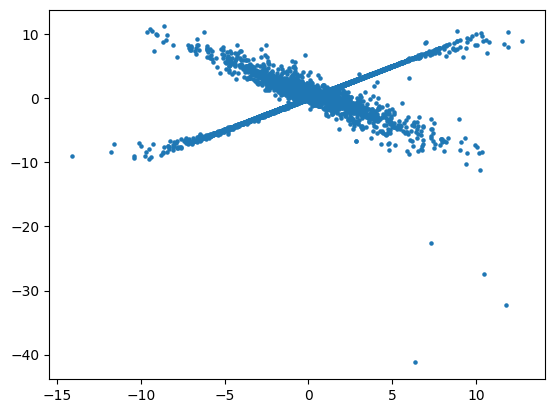

In [52]:
plt.scatter(np.log2(t['cancerMean']/t['GTExMean']), t['log2FoldChange'], s=5)

Text(0, 0.5, 'TPM Counts Xena')

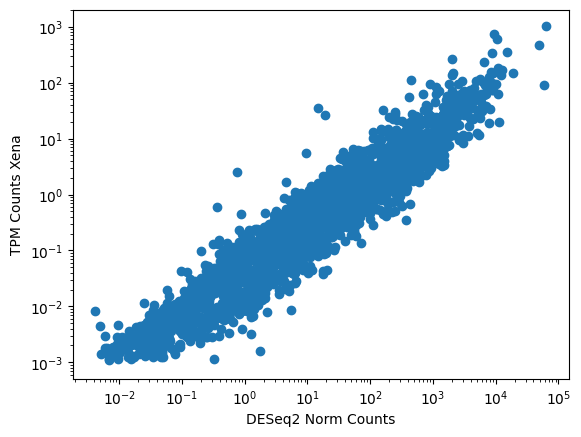

In [35]:
plt.scatter(de_stats.loc[df[df['TCGA']=='ACC'].index]['GTExMean'], df[df['TCGA']=='ACC']['Normal'])
plt.loglog()
plt.xlabel('DESeq2 Norm Counts')
plt.ylabel('TPM Counts Xena')

,Transcript,TCGA,GTEx,Description,Normal,Cancer
Transcript,,,,,,
ENST00000603548,ENST00000603548,ACC,adrenal gland,Adrenocortical Cancer,0.196313,0.032429
ENST00000525546,ENST00000525546,ACC,adrenal gland,Adrenocortical Cancer,0.123265,0.052039
ENST00000470968,ENST00000470968,ACC,adrenal gland,Adrenocortical Cancer,0.115062,0.046974
ENST00000462950,ENST00000462950,ACC,adrenal gland,Adrenocortical Cancer,0.055922,0.026455
ENST00000334919,ENST00000334919,ACC,adrenal gland,Adrenocortical Cancer,0.152018,0.054637
...,...,...,...,...,...,...
ENST00000414678,ENST00000414678,ACC,adrenal gland,Adrenocortical Cancer,6.895063,4.761912
ENST00000256078,ENST00000256078,ACC,adrenal gland,Adrenocortical Cancer,0.103969,0.104246
ENST00000444134,ENST00000444134,ACC,adrenal gland,Adrenocortical Cancer,0.063734,0.045935


In [13]:
de_stats.loc['ENST00000603548']

,Transcript,TCGA,GTEx,Description,Normal,Cancer
0,ENST00000603548,ACC,adrenal gland,Adrenocortical Cancer,0.196313,0.032429
1,ENST00000525546,ACC,adrenal gland,Adrenocortical Cancer,0.123265,0.052039
2,ENST00000470968,ACC,adrenal gland,Adrenocortical Cancer,0.115062,0.046974
3,ENST00000462950,ACC,adrenal gland,Adrenocortical Cancer,0.055922,0.026455
4,ENST00000334919,ACC,adrenal gland,Adrenocortical Cancer,0.152018,0.054637
...,...,...,...,...,...,...
81769,ENST00000414678,LAML,blood,Acute Myeloid Leukemia,1.333524,23.381299
81770,ENST00000256078,LAML,blood,Acute Myeloid Leukemia,0.247795,0.562349
81771,ENST00000444134,LAML,blood,Acute Myeloid Leukemia,0.082513,1.299851
81772,ENST00000507187,LAML,blood,Acute Myeloid Leukemia,0.340704,1.298097


In [12]:
df = pd.read_parquet('../../cache/gtex_tcga_pairs.parq')
for cancer in df['TCGA'].unique():
    de_stats = pd.read_csv(f"s3://velia-analyses-dev/VAP_20230329_tcga_differential_expression/deseq_output/{cancer}_GTEx_vs_TCGA.csv")
    de_stats.index = [i.split('.')[0] for i in de_stats['sample']]
    break
de_stats

,sample,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,cancerMean,GTExMean
ENST00000548312,ENST00000548312.5,2.052087,0.491126,0.329401,1.490967,1.359703e-01,1.861969e-01,2.503687,1.776109
ENST00000483781,ENST00000483781.5,1.655928,-1.713402,0.526383,-3.255050,1.133723e-03,2.297238e-03,0.710358,2.233776
ENST00000535093,ENST00000535093.1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
ENST00000338863,ENST00000338863.11,326.249258,-1.612434,0.144415,-11.165274,6.030513e-29,7.127056e-28,143.136884,438.151264
ENST00000570899,ENST00000570899.1,1.968687,-0.293168,0.362904,-0.807840,4.191828e-01,4.929810e-01,1.700521,2.132566
...,...,...,...,...,...,...,...,...,...
ENST00000402231,ENST00000402231.1,0.003714,-0.209228,3.016028,-0.069372,9.446934e-01,NaN,0.009791,0.000000
ENST00000463473,ENST00000463473.2,0.516628,-0.167580,0.620667,-0.270000,7.871601e-01,8.285060e-01,0.455059,0.554253
ENST00000380293,ENST00000380293.3,2.363100,-1.623524,0.294724,-5.508619,3.616606e-08,1.188136e-07,1.235040,3.052471
ENST00000288710,ENST00000288710.6,2.122495,-0.091270,0.350318,-0.260535,7.944508e-01,8.345164e-01,2.264438,3.200529


In [12]:
    # Loop over orfs, and populate sorf_table file with attributes of interest
    transcripts_to_map = []
    with jsonlines.open(os.path.join(OUTPUT_DIR, 'sorf_table.jsonlines'), mode = 'w') as fh:
        for current_orf in tqdm(orfs[:8]):
            # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
            overlapping_tids = query_overlapping_transcripts(current_orf, session)
            overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
            # exact_tids = find_seq_substring(nt, transcripts)
            # if len(tids)>0:
            # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
            exact_tids = transcript_matching_results[current_orf.id][-1]
            nt = transcript_matching_results[current_orf.id][0]
            aa = transcript_matching_results[current_orf.id][1]
            attributes = {
                'chr': current_orf.assembly.ucsc_style_name,
                'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
                'strand': current_orf.strand,
                'start': current_orf.start,
                'end': current_orf.end,
                'nucl': nt,
                'aa': aa,
                'transcripts_exact': exact_tids,
                'transcripts_overlapping': overlapping_tids,
                
            }
            transcripts_to_map+=exact_tids
            transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
            
            fh.write(attributes)

100%|██████████| 8/8 [00:00<00:00, 29.87it/s]


In [16]:
df = load_jsonlines_table('../../.cache/sorf_table.jsonlines')
df['transcripts_exact'].apply(lambda x: len(x)).iloc[:100]s


100%|██████████| 794/794 [00:02<00:00, 316.24it/s] 


0      2
1      0
2      0
3      0
4      0
5      1
6      0
7      0
8      0
9      1
10     0
11     1
12     1
13     2
14     0
15     0
16     3
17     0
18     1
19     0
20     3
21     1
22     3
23     0
24     1
25     0
26     0
27     1
28     1
29     2
30     0
31     1
32     1
33     1
34     0
35     2
36     0
37     0
38     0
39     1
40     8
41     0
42     3
43     0
44    24
45     0
46     4
47     0
48     0
49     1
50     0
51     3
52     2
53     0
54     1
55     2
56     0
57     3
58     4
59     0
60     5
61     3
62     0
63     0
64     8
65     0
66     0
67     1
68     0
69     1
70     1
71     1
72     0
73     1
74     3
75     1
76     0
77     0
78     1
79     0
80    12
81     0
82     3
83     4
84     2
85     0
86     2
87     0
88     0
89     6
90     4
91     0
92     0
93     0
94     1
95     7
96     7
97     0
98     1
99     1
Name: transcripts_exact, dtype: int64

In [7]:
exact_tids

[]

In [3]:
GENOME_REFERENCE_PATH = 's3://velia-annotation-dev/genomes/hg38/GRCh38.p13.genome.fa.gz'

In [4]:
with open('test_vtx.txt') as fhandle:
    ids = [int(i.replace('VTX-', '')) for i in fhandle.readlines()]
ids[:5]

[661740, 849972, 849974, 849976, 849977]

In [5]:
new_ids = [851390, 81996, 850636]
ids = new_ids+ids

In [6]:
# session.rollback()

In [194]:
find_seq_substring('ATGAGACGCTTCGACTGTCTCATCGGGGCACTTGTAATAAGCATCTTGGTGCCACTGAATGCAATGCTGTATTCAAATAATAGCTTTCATCTTCACTCTTTT',
                   transcripts)

['ENST00000665868.2|ENSG00000229989.6|OTTHUMG00000035888.5|OTTHUMT00000517878.1|MIR181A1HG-206|MIR181A1HG|3209|lncRNA|',
 'ENST00000436880.2|ENSG00000229989.6|OTTHUMG00000035888.5|OTTHUMT00000087436.2|MIR181A1HG-203|MIR181A1HG|2308|lncRNA|']

In [192]:
[i for i in orfs if i.id == 786168][0].nt_seq

'ATGATATTGCAGCTTTTTCTTTTGGTTGCGTGCAGTGAGAATCTGGGAGCTGAACCTGTTATCTGCATGGTCTTCAGAAATCAGGCAAACTCGGAAAATGCCAACGCCAAAAATGCTGATGGG'

In [8]:
session = base.Session()

In [207]:
SimpleNamespace(ucsc_style_name='test').ucsc_style_name

'test'

In [16]:
class OrfData(object):
    def __init__(self, orf_query_object):
        self.id = orf_query_object.id
        self.start = orf_query_object.start
        self.end = orf_query_object.end
        self.strand = orf_query_object.strand
        self.assembly = SimpleNamespace(ucsc_style_name=orf_query_object.assembly.ucsc_style_name)
        self.chrom_starts = orf_query_object.chrom_starts
        self.block_sizes = orf_query_object.block_sizes
        self.phases = orf_query_object.phases
        self.aa_seq = orf_query_object.aa_seq
        self.nt_seq = orf_query_object.nt_seq
        

In [17]:
orfs = session.query(Orf).filter(Orf.id.in_(ids)).all()
orfs = [OrfData(i) for i in orfs]
current_orf = orfs[0]
missing_orfs = set(ids) - set([i.id for i in orfs])
missing_orfs

set()

In [60]:
def load_xena_tcga_gtex_target():
    # xena_metadata = pd.read_table('../data/TcgaTargetGTEX_phenotype.txt', encoding='latin-1', index_col=0)
    # xena_expression = pd.read_feather('../data/xena_ucsc_phase1to6.feather')
    # xena_expression.index = xena_expression.pop('index')
    xena_expression = pd.read_parquet(os.path.join(CACHE_DIR, 'xena.parq'))
    xena_metadata = xena_expression[xena_expression.columns[:6]]
    xena_expression = xena_expression[xena_expression.columns[6:]]
    # xena_metadata = xena_metadata.loc[xena_expression.index]
    vtx_id_to_transcripts = load_jsonlines_table(os.path.join(CACHE_DIR, 'sorf_table.jsonlines'))
                                                 # index_col='vtx')
    # vtx_id_to_transcripts = json.load(open('../data/vtx_to_ensembl_ids.json', 'r'))
    return xena_metadata, xena_expression, vtx_id_to_transcripts
CACHE_DIR = '../../.cache'
a,b,c = load_xena_tcga_gtex_target()

100%|██████████| 794/794 [00:05<00:00, 152.54it/s] 


,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,GCGGCAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACC,AAAQREAQEGDLQGQEGAEASHAGGPAADHYSGAAHAGRGRALDRGVCVRGHAPHHH,"[ENST00000700399, ENST00000700400]","[rna-XM_011542909, ENST00000525141, ENST00000596676, rna-XM_011542911, rna-XM_011542907, rna-XM_017018020, rna-XM_047427266, C, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,GGAACCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAG...,GTPLPGWVHSHDGEYPTGEKNDREWPPVWRLFPVPVMALLPPTTR*LGDPAAEGGRGATGTGGL*ERGIEVHSLP*RRLLRDEWSPGATGGAGGSREAAAKGGGGPWHRAQQGSHLPVAARETAPGALQAAGGPAAGQGT*RPACHQEEPG,[],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GCCCGTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGG...,ARAEAAGPRAAQEAA*SRRPVHLRAARRLPAHAARGARRRRLRGHLVPEPPRRRAAPRAPGAPRGGPALPAAARRPAVRSALACRPAAVLPPGSGALHAGRGAGRHGRGAPGGGCRQARRGTPPRDAAPPGPLPPQRGPRAERRHR,[],"[C, ENST00000301200]"
VTX-0007541,chr1,VTX-0007541,+,160370732,160371133,ATGATGCTCAACTCAGACACCATGGAGCTGGACCTGCCGCCCACCCACTCAGAGACTGAGTCGGGCTTCAGTGACTGTGGGGGCGGGGCGGGCCCTGATGGTGCCGGGCCTGGGGGTCCGGGAGGGGGCCAGGCCCGAGGCCCAGAGCCGGGAGAGCCTGGCCGGAAAGACCTGCAGCATCTGAGCCGCGAGGAGC...,MMLNSDTMELDLPPTHSETESGFSDCGGGAGPDGAGPGGPGGGQARGPEPGEPGRKDLQHLSREERRRRRRATAKYRTAHATRERIRVEAFNLAFAELRKLLPTLPPDKKLSKIEILRLAICYISYLNHVLDV,[],[ENST00000302101]
VTX-0009335,chr14,VTX-0009335,+,20747581,20748024,ATGACATCCTCTCTAAAGATTTGGGGCATACTCTTGGCCCTGCTTTGCATCCTTTGCAGGCTGTGTGTATACAGTAACAACATTTACTGGAGAGAATTCATAAAACTTCATTACTTAAGTCCAAGTCGAGAATTCAAAGAGTACAAATGTGATGTCCTCATGAGAGAAAAAGAGGCTCTGAAAGGCAAGAGCTTTC...,MTSSLKIWGILLALLCILCRLCVYSNNIYWREFIKLHYLSPSREFKEYKCDVLMREKEALKGKSFHMFIYSLWFKIQRACINEKGSDRYRNAYVWAPGALKVLECHWEKYNNRYTESRSFSYIEFHCGVDGYVDNIEDLRIIEPISN,[],"[ENST00000326842, rna-XM_017020934, C]"
...,...,...,...,...,...,...,...,...,...
VTX-0852788,chr1,VTX-0852788,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]
VTX-0852790,chr1,VTX-0852790,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]
VTX-0852794,chr1,VTX-0852794,,-1,-1,,,"[ENST00000456328, ENST00000450305, ENST00000488147, ENST00000619216, ENST00000473358, ENST00000469289, ENST00000607096, ENST00000417324, ENST00000461467, ENST00000606857, ENST00000642116, ENST0000...",[]


In [55]:
import jsonlines
import json
from tqdm import tqdm
def load_jsonlines_table(path_to_file):
    with open(path_to_file) as fh:
        results = []
        for line in tqdm(fh.readlines()):
            results.append(json.loads(line))
    df = pd.DataFrame(results)
    df.index = df['vtx']
    return df
t = load_jsonlines_table('../../.cache/sorf_table.jsonlines')
t.head(3)

100%|██████████| 794/794 [00:02<00:00, 361.50it/s] 


,chr,vtx,strand,start,end,nucl,aa,transcripts_exact,transcripts_overlapping
vtx,,,,,,,,,
VTX-0007082,chr11,VTX-0007082,-,93479010,93479189,GCGGCAGCTCAAAGGGAAGCCCAAGAAGGAGACCTCCAAGGACAAGAAGGAGCGGAAGCAAGCCATGCAGGAGGCCCGGCAGCAGATCACTACAGTGGTGCTGCCCACGCTGGCCGTGGTCGTGCTCTTGATCGTGGTGTTTGTGTACGTGGCCACGCGCCCCACCATCACC,AAAQREAQEGDLQGQEGAEASHAGGPAADHYSGAAHAGRGRALDRGVCVRGHAPHHH,"[ENST00000700399, ENST00000700400]","[rna-XM_011542909, ENST00000525141, ENST00000596676, rna-XM_011542911, rna-XM_011542907, rna-XM_017018020, rna-XM_047427266, C, ENST00000298966, ENST00000527149, C]"
VTX-0007146,chr17,VTX-0007146,-,57744811,57745272,GGAACCCCTCTACCAGGCTGGGTCCATTCTCATGACGGTGAATACCCTACAGGGGAAAAAAATGATAGAGAGTGGCCTCCAGTCTGGAGACTTTTCCCTGTCCCAGTCATGGCCCTCCTGCCTCCCACCACCCGCTGACTTGGAGATCCTGCAGCAGAAGGTGGCCGGGGTGCAACGGGAACTGGAGGACTTTAAG...,GTPLPGWVHSHDGEYPTGEKNDREWPPVWRLFPVPVMALLPPTTR*LGDPAAEGGRGATGTGGL*ERGIEVHSLP*RRLLRDEWSPGATGGAGGSREAAAKGGGGPWHRAQQGSHLPVAARETAPGALQAAGGPAAGQGT*RPACHQEEPG,[],[ENST00000299415]
VTX-0007396,chr19,VTX-0007396,-,54465101,54465547,GCCCGTGCTGAAGCAGCTGGGCCCCGCGCAGCCCAAGAAGCGGCCTGATCGCGGCGCCCTGTCCATCTCCGCGCCGCTCGGCGACTTCCGGCACACGCTGCACGTGGGGCGCGGCGGCGACGCCTTCGGGGACACCTCGTTCCTGAGCCGCCACGGCGGCGGGCCGCCCCCCGAGCCCCGGGCGCCCCCCGCGGGG...,ARAEAAGPRAAQEAA*SRRPVHLRAARRLPAHAARGARRRRLRGHLVPEPPRRRAAPRAPGAPRGGPALPAAARRPAVRSALACRPAAVLPPGSGALHAGRGAGRHGRGAPGGGCRQARRGTPPRDAAPPGPLPPQRGPRAERRHR,[],"[C, ENST00000301200]"


In [ ]:
transcript_matching_results = run_id_mapping_parallel(orfs, NCPU = 8)

/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
  0%|          | 0/794 [00:00<?, ?it/s]/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/Bio/Seq.py:2804: BiopythonWarning: Partial codon, len(sequence

In [11]:
import numpy as np

In [12]:
[i for i in np.where(np.array([i.chrom_starts.count(';') for i in orfs])>0)[0] if orfs[i].strand=='-']

[264,
 267,
 270,
 276,
 293,
 303,
 304,
 313,
 314,
 315,
 316,
 320,
 331,
 332,
 343,
 344,
 345,
 353,
 354,
 355,
 356,
 357,
 385,
 386,
 387,
 388,
 389,
 390,
 401,
 402,
 404,
 408,
 409,
 410,
 411,
 434,
 435,
 439,
 440,
 448,
 456,
 457,
 458,
 459,
 460,
 465,
 468,
 469,
 479,
 480,
 496,
 498,
 501,
 506,
 511,
 513,
 517,
 522,
 523,
 525,
 526,
 527,
 528,
 529,
 530,
 538,
 539,
 541,
 545,
 546,
 547,
 548,
 550,
 552,
 557,
 558,
 560,
 561,
 563,
 566,
 570,
 571,
 572,
 574,
 577,
 578,
 580,
 581,
 583,
 584,
 587,
 588,
 591,
 593,
 594,
 602,
 603,
 605,
 615,
 618,
 622,
 624,
 625,
 626,
 627,
 629,
 632,
 635,
 639,
 644,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 657,
 660,
 661,
 662,
 667,
 671,
 672,
 676,
 678,
 680,
 681,
 683,
 684,
 685,
 687,
 689,
 691,
 693,
 694,
 697,
 719,
 721,
 723]

In [40]:
orfs[259]

ORF: 849976, VTX-0849976, CXCL2_74964836_75aa,(-)chr4:74098795-74099120

In [121]:
reference[chrom][0:3]

>chr4:1-3
NNN

In [114]:
reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].complement.seq[::-1]

'GAGCGCCCCTGGCCACTGAACTGCGCTGCCAGTGCTTGCAGACCCTGCAGGGAATTCACCTCAAGAACATCCAAAGTGTGAAGGTGAAGTCCCCCGGACCCCACTGCGCCCAAACCGAAGTCATG'

<module 'pyfaidx' from '/home/ec2-user/anaconda/envs/veliadash/lib/python3.11/site-packages/pyfaidx/__init__.py'>

In [41]:

        o = orfs[293]
        blocks = [int(x) for x in o.block_sizes.split(';')]
        chrom_starts = [int(x) - 1 for x in o.chrom_starts.split(';')]
        start = o.start - 1
        strand = o.strand
        chrom = o.assembly.ucsc_style_name
        seqs = []
        for i, block in enumerate(blocks):
            if i == len(blocks)-1 and strand == '+':
                blocks[i] = blocks[i] - 3
                
            elif i == 0 and strand == '-':
                blocks[i] = blocks[i] - 3
                chrom_starts[i] = chrom_starts[i]+3
                # blocks[i] = blocks[i] + 
                
            if strand == '-':
                seqs.append(reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].complement.seq[::-1].upper())
            else:
                seqs.append(reference[chrom][chrom_starts[i]:(chrom_starts[i] + blocks[i])].seq.upper())
        
        if strand == '-':
            seqs.reverse()
        seq = ''.join(seqs)
        strand

'-'

In [42]:
o.nt_seq == seq

False

In [43]:
seqs

['GTGCCTTTTCAGTTTTGGCTGTTTTGGCTGATATTGCACCTTCCACAGATGACTTGG',
 'AGTGCTGGGATGAGAAATTTACCTGCACAAGGCTCTACTCTGTGCATCGGCCGGTTAAACAATGCATTCATCAGTTATGCTTCACCAG',
 'ACGACGTATGTACATCGTCAACAAGGAGATCTGCTCTCGTCTTGTCTGTAAGGAACACGAAG']

In [31]:
seqs

['GTGCCTTTTCAGTTTTGGCTGTTTTGGCTGATATTGCACCTTCCACAGATGACTTGG',
 'AGTGCTGGGATGAGAAATTTACCTGCACAAGGCTCTACTCTGTGCATCGGCCGGTTAAACAATGCATTCATCAGTTATGCTTCACCAG',
 'TTTACGACGTATGTACATCGTCAACAAGGAGATCTGCTCTCGTCTTGTCTGTAAGGAACACGAAGCTA']

In [25]:
o.aa_seq

'VPFQFWLFWLILHLPQMTWSAGMRNLPAQGSTLCIGRLNNAFISYASPVYDVCTSSTRRSALVLSVRNTKL'

In [172]:
    orf = orfs[444]
    # if orf.start == -1 or orf.end == -1:
        # return None
    chrom = orf.assembly.ucsc_style_name
    blocks = list(zip(orf.chrom_starts.split(';'), orf.block_sizes.split(';'), orf.phases.split(';')))
    strand = orf.strand
    nucl = []
    for ix, (start, size, phase) in enumerate(blocks):
        start = int(start)-1
        size = int(size)
        phase = int(phase)
        if strand == '-' and ix == 0:
            # start = start-3
            size += 3
        if strand == '-':
            s = reference[chrom][start : start+size]
            s = s.complement.seq[::-1]
        else:
            s = reference[chrom][start : start+size]
            s = s.seq
        nucl.append(s)
    # if strand == '-' and len(blocks)>1:
    #     nucl[-1] = reference[chrom][start+3 : start+size].complement.seq[::-1]
    # elif strand == '-' and len(blocks)==1:
    #     nucl[0] = nucl[0][1:]
    if strand == '-':
        nucl = nucl[::-1]
    #     nucl = ' '.join(nucl)
    # else:
    #     nucl = ' '.join(nucl)

In [173]:
orf.aa_seq

'VVESAIHTLVPLFFLAVVVTQTEGTTTEVECPTEGTTTRTSEDEETIVATKINLRATTSGSRV'

In [174]:
nucl

['GTGGTGGAATCGGCTATCCATACCCTCGTGCCCCTGTTTTTCCTGGCCGTGGTAGTTACTCAAACAGAGGGAACTACAACAGAGGTGGAATGCCCAACAGAGGGAACTACAACCAG',
 'AACTTCAGAGGACGAGGAAACAATCGTGGCTACAAAAATCAATCTCAGGGCTACAACCAGTGGCAGCAGGGTG']

In [100]:
chrom, blocks, strand

('chr4', [('74098798', '122', '2'), ('74099021', '100', '0')], '-')

In [53]:
def create_comparison_groups_xena_tcga_vs_normal(xena):
    groups = {}
    for ix, row in tqdm(tissue_pairs.iterrows()):
        # Normal sample indexes for specific tissues
        normal = xena.index[(xena['_primary_site'].str.lower() == row['GTEx Tissue Type'].lower())
                                & (xena['_sample_type'] == 'Normal Tissue')]
        # Cancer sample indexes
        cancer = xena.index[(xena['detailed_category'].str.lower() == row['Description'].lower())
                                & (xena['_sample_type'] == 'Primary Tumor')]
        groups[row['TCGA Cancer Type']] = {'normal_indices': normal, 'cancer_indices': cancer,
                                       'GTEx Tissue': row['GTEx Tissue Type'], 'TCGA Cancer': row['Description']}
    return groups

In [61]:
import numpy as np

In [67]:
r

NameError: name 'r' is not defined

In [71]:
xena.loc[g['normal_indices']][xena.columns[6:]].mean(axis=0)

ENST00000302101   -3.248698
ENST00000299415   -8.989675
ENST00000596676   -7.941365
ENST00000527149    1.095069
ENST00000525141    4.498505
ENST00000326842   -9.749581
ENST00000301200    2.436686
ENST00000298966    2.714475
dtype: float64

In [83]:
'ENST00000253122' in xena.columns

False

In [88]:
xena = pd.read_parquet('../../.cache/xena.parq')
tissue_pairs = pd.read_parquet('../../.cache/gtex_tcga_pairs.parq')
normal_vs_gtex_expression = pd.read_parquet('../../.cache/gtex_tcga_pairs.parq')
normal_vs_gtex_expression.index = normal_vs_gtex_expression['Transcript']
normal_vs_gtex_expression.loc['ENST00000253122']

,Transcript,TCGA,GTEx,Description,Normal,Cancer
Transcript,,,,,,
ENST00000253122,ENST00000253122,ACC,adrenal gland,Adrenocortical Cancer,33.600359,49.264961
ENST00000253122,ENST00000253122,BLCA,bladder,bladder urothelial carcinoma,37.728066,40.941452
ENST00000253122,ENST00000253122,BRCA,breast,breast invasive carcinoma,16.239323,14.747659
ENST00000253122,ENST00000253122,CESC,cervix uteri,Cervical & Endocervical Cancer,15.126069,51.724043
ENST00000253122,ENST00000253122,CHOL,liver,cholangiocarcinoma,1.640086,16.829578
ENST00000253122,ENST00000253122,COAD,colon,colon adenocarcinoma,45.299947,24.193626
ENST00000253122,ENST00000253122,DLBC,blood,Diffuse Large B-Cell Lymphoma,4.209813,1.067385
ENST00000253122,ENST00000253122,ESCA,esophagus,esophageal carcinoma,31.661973,46.371972
ENST00000253122,ENST00000253122,GBM,brain,glioblastoma multiforme,38.757408,57.155692


In [ ]:
cancer = xena.index[(xena['detailed_category'].str.lower() == row['Description'].lower())
                                & (xena['_sample_type'] == 'Primary Tumor')]

In [81]:
normal_vs_gtex_expression

,Transcript,Cancer,GTEx,Description,Normal,Cancer
0,ENST00000302101,ACC,adrenal gland,Adrenocortical Cancer,-3.248698,-4.078971
1,ENST00000299415,ACC,adrenal gland,Adrenocortical Cancer,-8.989675,-8.215799
2,ENST00000596676,ACC,adrenal gland,Adrenocortical Cancer,-7.941365,-8.554186
3,ENST00000527149,ACC,adrenal gland,Adrenocortical Cancer,1.095069,-0.681665
4,ENST00000525141,ACC,adrenal gland,Adrenocortical Cancer,4.498505,4.025062
...,...,...,...,...,...,...
243,ENST00000527149,UVM,skin,uveal melanoma,-5.015234,-4.888420
244,ENST00000525141,UVM,skin,uveal melanoma,2.904968,1.755980
245,ENST00000326842,UVM,skin,uveal melanoma,-9.390312,-8.936177
246,ENST00000301200,UVM,skin,uveal melanoma,3.299456,3.419008


In [80]:
normal_vs_gtex_expression[normal_vs_gtex_expression['Transcript'] == 'ENST00000253122']

,Transcript,Cancer,GTEx,Description,Normal,Cancer


In [33]:
metadata = pd.read_table('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/TcgaTargetGTEX_phenotype.txt')
metadata

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xca in position 15827: invalid continuation byte

Index(['GTEX-S4Q7-0003-SM-3NM8M', 'TCGA-19-1787-01', 'TCGA-S9-A7J2-01',
       'GTEX-QV31-1626-SM-2S1QC', 'TCGA-G3-A3CH-11',
       'GTEX-13OVI-1026-SM-5L3EM', 'GTEX-13OW5-0626-SM-5J2N2',
       'GTEX-XUZC-2026-SM-4BRW9', 'TCGA-EK-A2RE-01', 'TCGA-D5-5538-01',
       ...
       'TCGA-IB-7885-01', 'TCGA-B6-A0IA-01', 'GTEX-1117F-2826-SM-5GZXL',
       'TCGA-VQ-AA6F-01', 'TCGA-BR-8588-01', 'GTEX-11ZTS-3326-SM-5LU9Y',
       'TCGA-DD-A115-01', 'GTEX-ZA64-2126-SM-5Q5A8', 'TCGA-FV-A3I0-11',
       'GTEX-XV7Q-0426-SM-4BRVN'],
      dtype='object', length=19126)

In [39]:
    transcripts_to_load = transcript_matching_results
    
    xena_transcripts = pd.read_csv('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/xena_transcript_names.csv')
    if transcripts_to_load is None:
        transcripts_to_map = xena_transcripts['Xena Transcripts']
    else:
        overlapping_xena_sorf_transcripts = set(xena_transcripts['Xena Transcripts']).intersection(set(transcripts_to_load))
    xena = pd.read_feather('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/xena.feather', columns = ['index']+list(overlapping_xena_sorf_transcripts))
    xena.index = xena.pop('index')
    metadata = pd.read_table('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/TcgaTargetGTEX_phenotype.txt',
                             encoding = "ISO-8859-1", index_col=0)
    metadata = metadata[~metadata['_primary_site'].isna()]
    ordr = xena.index.intersection(metadata.index)
    xena = xena.loc[ordr].copy()
    metadata = metadata.loc[ordr].copy()

    tissue_pairs = pd.read_excel('s3://velia-data-dev/VDC_004_annotation/20230329_tcga_data/Xena/GTEx_TCGA_comparisons.xlsx')
    tissue_pairs['GTEx Tissue Type'] = tissue_pairs['GTEx Tissue Type'].str.replace('whole ', '')
    tissue_pairs = tissue_pairs[tissue_pairs['GTEx Tissue Type']!='--']
    
    # tissue_pairs.head(4)

,TCGA Cancer Type,Description,GTEx Tissue Type,Ambiguity,Unnamed: 4,Unnamed: 5
0,ACC,Adrenocortical Cancer,adrenal gland,N,NaN,NaN
1,BLCA,bladder urothelial carcinoma,bladder,N,NaN,NaN
2,BRCA,breast invasive carcinoma,breast,N,NaN,NaN
3,CESC,Cervical & Endocervical Cancer,cervix uteri,N,NaN,NaN


In [35]:
metadata

,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study
sample,,,,,,
TCGA-V4-A9EE-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-VD-AA8N-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-V4-A9EI-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-VD-AA8O-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
TCGA-WC-A888-01,Uveal Melanoma,Uveal Melanoma,Eye,Primary Tumor,Male,TCGA
...,...,...,...,...,...,...
TARGET-20-PANPKN-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET
TARGET-20-PANLIR-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET
TARGET-20-PAPAWN-09,Acute Myeloid Leukemia,Acute Myeloid Leukemia,White blood cell,Primary Blood Derived Cancer - Bone Marrow,Male,TARGET


In [21]:
transcript_matching_results[7082][-1]

['ENST00000525141', 'ENST00000298966', 'ENST00000527149', 'ENST00000596676']

In [22]:
overlapping_tids

['XM_017023741.2', 'ENST00000329565.6']

In [25]:
transcripts_to_map = []
with jsonlines.open('sorf_table.jsonlines', mode = 'w') as fh:
    for current_orf in tqdm(orfs):
        # nt, aa = extract_nucleotide_sequence_broken_psl_starts(current_orf, reference)
        overlapping_tids = query_overlapping_transcripts(current_orf, session)
        overlapping_tids = [[i.split('.')[0] for i in [t.ensembl_id, t.refseq_id, t.chess_id] if i][0] for t in overlapping_tids]
        # exact_tids = find_seq_substring(nt, transcripts)
        # if len(tids)>0:
        # exact_tids = [i.split('|')[0].split('.')[0] for i in exact_tids]
        exact_tids = transcript_matching_results[current_orf.id][-1]
        nt = transcript_matching_results[current_orf.id][0]
        aa = transcript_matching_results[current_orf.id][1]
        attributes = {
            'chr': current_orf.assembly.ucsc_style_name,
            'vtx': f"VTX-{str(current_orf.id).zfill(7)}",
            'strand': current_orf.strand,
            'start': current_orf.start,
            'end': current_orf.end,
            'nucl': nt,
            'aa': aa,
            'transcripts_exact': exact_tids,
            'transcripts_overlapping': overlapping_tids,
            
        }
        transcripts_to_map+=exact_tids
        transcripts_to_map+=[i.split('.')[0] for i in overlapping_tids if i.startswith('ENST')]
        
        fh.write(attributes)
        # break

  1%|          | 8/644 [00:00<00:49, 12.85it/s]


KeyError: 11192

In [ ]:
assembly_ids = {}

for assembly in session.query(base.Assembly).all():
    if assembly.ucsc_style_name.startswith('chr') and len(assembly.ucsc_style_name) < 6:
        assembly_ids[assembly.ucsc_style_name] = assembly
    else:
        assembly_ids[assembly.genbank_accession] = assembly

In [ ]:
assembly_ids

In [17]:
from Bio import SeqIO

In [21]:
with smart_open.open('s3://velia-annotation-dev/gencode/v42/gencode.v42.transcripts.fa.gz') as f:
    seqs = SeqIO.to_dict(SeqIO.parse(f, 'fasta'))

In [24]:
# seqs.keys()

# Map transcripts

In [253]:
targets = {
    'VTX-0851390': 'ATGGCCGAGAGGCCGGGGCCTCCGGGCGGCGCCGTGTCCGCGACCGCGTACCCTGACACCCCCGCGGAATTCCCTCCGCACCTCCAGGCGGGTGCGATGCGGCGCCGCTTTTGGGGCGTATTCAACTGTCTGTGCGCCGGCGCGTTCGGGGCCCTGGCCGCCGCCTCCGCCAAGCTGGCCTTCGGCAGCGAGGTGAGCATGGGTTTATGCGTCTTAGGCATTATTGTGATGGCGAGCACCAATTCTCTGATGTGGACCTTCTTTAGCCGGGGCCTCAGTTTCTCCATGTCTTCAGCCATTGCATCTGTCACAGTGACTTTTTCAAATATCCTCAGCTCGGCCTTCCTGGGCTATGTGCTGTATGGAGAGTGCCAGGAGGTCTTGTGGTGGGGAGGAGTGTTCCTTATTCTCTGCGGACTCACCCTAATCCACAGGAAGCTCCCACCCACCTGGAAGCCCCTTCCACACAAGCAGCAG',
    'VTX-0081996': 'ATGGCGGATGTGTCAGAGAGGACACTGCAGTTGTCCGTGCTAGTAGCCTTCGCTTCTGGAGTACTCCTGGGCTGGCAGGCGAACCGACTGCGGAGGCGCTACTTGGACTGGAGGAAAAGGAGGCTGCAGGACAAGCTGGCGGCGACGCAGAAGAAGCTGGACCTGGCC',
    'VTX-0087927': 'ATGAACGGCTCTCAGGCGGGCGCCGCGGCTCAGGCCGCCTGGCTGAGCTCCTGCTGTAACCAGTCGGCGTCGCCGCCGGAGCCCCCCGAGGGGCCGCGCGCGGTGCAGGCGGTGGTGCTCGGCGTGCTGTCCCTGCTGGTGCTTTGCGGGGTCCTGTTCCTGGGCGGCGGCCTCCTCCTCCGCGCCCAGGGCCTGACAGCGCTGCTGACCCGCGAGCAGCGCGCGTCCCGCGAGCCCGAGCCGGGCAGTGCCAGCGGAGAGGACGGCGACGACGACTCC',
    'VTX-0085840': 'ATGCTCCTGGGGAGTCTGTGGGGAAGATGCCATCCAGGGCGCTGTGCGCTCTTCCTCATCCTCGCCCTCCTGCTGGACGCGGTCGGCCTGGTCCTTTTGCTGCTGGGGATCTTGGCCCCCCTGAGTTCCTGGGACTTCTTCATCTACACAGGTGCCCTGATCCTGGCTCTCAGCCTACTGCTCTGGATCATCTGGTATTCCCTCAACATTGAGGTGTCTCCTGAAAAACTGGACCTG',
    'VTX-0087707': 'ATGACCTCCTGGCCAGGTGGCAGCTTTGGCCCTGACCCGCTCCTGGCCCTGCTGGTGGTGATCCTGCTAGCACGCCTCATCCTGTGGTCCTGCCTCGGGACCTACATCGACTACAGACTGGCCCAGCGGCGGCCCCAGAAACCCAAGCAGGAC',
}
for i, s in targets.items():
    hit = find_seq_substring(s, transcripts)
    print(i, hit)

VTX-0851390 ['ENST00000302392.5|ENSG00000169964.8|OTTHUMG00000133092.3|OTTHUMT00000256750.3|TMEM42-201|TMEM42|977|protein_coding|']
VTX-0081996 ['ENST00000611969.5|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000477505.2|MTLN-203|MTLN|427|protein_coding|', 'ENST00000414416.2|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000253918.4|MTLN-201|MTLN|2051|protein_coding|', 'ENST00000426713.1|ENSG00000175701.11|OTTHUMG00000131194.5|OTTHUMT00000338107.3|MTLN-202|MTLN|461|protein_coding|']
VTX-0087927 ['ENST00000546390.2|ENSG00000284791.2|OTTHUMG00000169615.4|OTTHUMT00000405071.2|SMIM41-201|SMIM41|1430|protein_coding|']
VTX-0085840 ['ENST00000581851.2|ENSG00000263429.4|OTTHUMG00000132847.7|OTTHUMT00000256321.4|TMEM238L-202|TMEM238L|1535|protein_coding|']
VTX-0087707 ['ENST00000641568.1|ENSG00000284713.2|OTTHUMG00000172974.2|OTTHUMT00000491249.1|SMIM38-202|SMIM38|2695|protein_coding|', 'ENST00000686937.1|ENSG00000284713.2|OTTHUMG00000172974.2|-|SMIM38-204|SMIM38|5447|protein_coding|', 'E

In [251]:
import gzip
import fsspec
from pyfaidx import Fasta
import pandas as pd
from tqdm import tqdm

# deduped_conservation = pd.read_parquet('deduped_phylocsf_length_filtered.parq')
transcripts = Fasta('./gencode.v42.transcripts.fa')

def find_seq_substring(query, target_dict):
    return [k for k, s in target_dict.items() if query.lower() in s[:].seq.lower()]

def extract_sequence(reference, chrom, strand, block_starts, block_sizes):
    s = reference[chrom]
    sequence = ''
    for start, length in zip(block_starts, block_sizes):
        end = start + (3*(length-1)) + 3
        sequence += str(s[start : end])
    sequence+=str(s[end:end+3])
    return sequence

def pfunc(row):
    ix = row['qName']
    starts = tuple(map(int, row['tStarts'].strip(',').split(',')))
    sizes = tuple(map(int, row['blockSizes'].strip(',').split(',')))
    s = extract_sequence(genes, row['tName'], row['strand'], starts, sizes)
    # print(row['strand'], s[:3], s[-3:])
    # blat_sequences[row['qName']] = s
    matches = find_seq_substring(s, transcripts)
    if len(matches)>0:
        transcript_names = [i.split('|')[0].split('.')[0] for i in matches]
        gene_names = [i.split('|')[5] for i in matches]
        return ix, {'transcripts': transcript_names, 'genes': gene_names, 'sequence': s}
    else:
        return ix, {'transcripts': [], 'genes': [], 'sequence': s}
    
# import multiprocessing as mp
# with mp.Pool(120) as ppool:
#     annotations = {}
#     ixes, rows = list(zip(*deduped_conservation.iterrows()))
#     for r in tqdm(ppool.imap(pfunc, rows), total=50000):#, total=signalp_and_conserved.shape[0]):
#         annotations[r[0]] = r[1]